In [29]:
import torch
import random
from draft_gen import beam_generate_draft_from_cut
from draft_tokenizer import DraftTokenizer
#from draft_utils import get_token_name  # optional helper if you have a pretty formatter
# we have a vocab json which is gonnabe a dictionary#
#
""" def load_from_files(cls, vocab_dir="vocab"):
        with open(f"{vocab_dir}/vocab.json") as f:
            vocab = json.load(f)
        with open(f"{vocab_dir}/reverse_vocab.json") as f:
            reverse_vocab = json.load(f)
        reverse_vocab = {int(k): v for k, v in reverse_vocab.items()}
        with open(f"{vocab_dir}/dense_map.json") as f:
            dense_map = json.load(f)
        dense_map = {int(k): v for k, v in dense_map.items()}

        with open(f"{vocab_dir}/hero_id_to_name.json") as f:
            hero_id_to_name = json.load(f)
        hero_id_to_name = {int(k): v for k, v in hero_id_to_name.items()}

        return cls(vocab, reverse_vocab, dense_map, hero_id_to_name)
"""
from draft_dataset import split_tokenized_docs

# === ⚙️ Load Tokenizer ===
t = DraftTokenizer.load_from_files()
import json
# === 📜 Load Pre-tokenized Data (or re-tokenize) ===
with open('draft_results.json', 'r') as f:
    draft_data = json.load(f)

docs = [seq for _, seq in draft_data.items()]
tokenized_docs = [t(doc, return_tensors='pt') for doc in docs]

# === 🔍 Sample a Few Interesting Drafts ===
_, _, test_docs = split_tokenized_docs(tokenized_docs, tokenizer=t, mid=True)
test_cases = random.sample(test_docs, k=3)  # or manually choose slices

# === 📦 Load Model ===
from transformers import GPT2Config
from draft_bert import DraftGPT2ForCausalLM

gconfig = GPT2Config.from_pretrained("./model/final_gpt2_model")
gmodel = DraftGPT2ForCausalLM(gconfig)
gmodel.load_state_dict(torch.load("./model/final_gpt2_model/pytorch_model.bin"))
gmodel.eval().to('cuda' if torch.cuda.is_available() else 'cpu')

# === 🧪 Try Beam Generation ===
for i, sample in enumerate(test_cases):
    print(f"\n===== 🧠 Beam Search Generation: Case {i+1} =====")

    input_ids = sample['input_ids']
    valid_len = (sample['attention_mask'] > 0).sum().item()

    print("👀 Original Sequence:")
    print(sample)
    print([t.decode_token_id(tok.item()) for tok in input_ids[:valid_len]])

    beams = beam_generate_draft_from_cut(
        model=gmodel,
        tokenizer=t,
        sequence=sample,
        start_pos=18,
        beam_width=3,
        depth=6,
        max_len=32,
        model_type='gpt'
    )

    top_beam = beams[0]
    final_tokens = top_beam["input_ids"]
    decoded = [t.decode_token_id(tok.item()) for tok in final_tokens if tok.item() != t.pad_token_id]

    print("\n✅ Top Beam (Best Sequence):")
    print(" →", decoded)
    print(f"🧮 Score: {top_beam['score']:.2f}")

    print("\n📊 Generation Log:")
    for step in top_beam["log"]:
        tok = t.decode_token_id(step["predicted_token"])
        print(f"  Pos {step['position']:2d}: {tok:25s} (p={step['prob']:.4f})")

    print("\n📈 Top-k Alternatives Per Step:")
    for step in top_beam["log"]:
        names = [t.decode_token_id(tok_id) for tok_id in step.get("topk_ids", [])]
        probs = step.get("topk_probs", [])
        print(f"  Step {step['position']}:")
        for name, p in zip(names, probs):
            print(f"    - {name:25s}: {p:.4f}")

    print("="*60)






===== 🧠 Beam Search Generation: Case 1 =====
👀 Original Sequence:
{'input_ids': tensor([254, 179, 239, 224, 223, 233, 240, 209,  25,  67, 189, 170, 218,  73,
         17,  66,   2,  52,  26, 138, 230, 142, 243,  47, 108, 255, 252, 252,
        252, 252, 252, 252]), 'attention_mask': tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False]), 'position_ids': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24,  0,  0,  0,  0,  0,  0,  0]), 'team_ids': tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0]), 'type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0])}
['[CLS]', 'ban_Dark Seer', 'ban_Dark Willow

In [30]:
test_cases[0]

{'input_ids': tensor([254, 179, 239, 224, 223, 233, 240, 209,  25,  67, 189, 170, 218,  73,
          17,  66,   2,  52,  26, 138, 230, 142, 243,  47, 108, 255, 252, 252,
         252, 252, 252, 252]),
 'attention_mask': tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True, False, False, False, False,
         False, False]),
 'position_ids': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24,  0,  0,  0,  0,  0,  0,  0]),
 'team_ids': tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0]),
 'type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0])}

In [31]:
# === 📦 Load BERT Model ===
from transformers import BertConfig
from draft_bert import DraftBertForMaskedLM

bconfig = BertConfig.from_pretrained("./model/final_bert_model")
bmodel = DraftBertForMaskedLM(bconfig)
bmodel.load_state_dict(torch.load("./model/final_bert_model/pytorch_model.bin"))
bmodel.eval().to('cuda' if torch.cuda.is_available() else 'cpu')

DraftBertForMaskedLM(
  (bert): DraftBertModel(
    (embeddings): DraftEmbeddings(
      (token_embeddings): Embedding(256, 64)
      (position_embeddings): Embedding(32, 64)
      (team_embeddings): Embedding(2, 64)
      (type_embeddings): Embedding(2, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=64, out_features=64, bias=True)
              (LayerNorm): LayerNorm((64,), eps=1

In [32]:
# Ensure your model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bmodel.to(device)
bmodel.eval()

# Prepare the sample (e.g., from your `test_cases`)
sample = test_cases[0]  # or any index
sample = {k: v.unsqueeze(0).to(device) for k, v in sample.items()}  # Add batch dim

# Run the model with attention outputs
with torch.no_grad():
    outputs = bmodel(
        input_ids=sample["input_ids"],
        attention_mask=sample["attention_mask"],
        position_ids=sample["position_ids"],
        team_ids=sample["team_ids"],
        type_ids=sample["type_ids"],
        output_attentions=True
    )

# Access attention maps
attentions = outputs["attentions"]  # list of [batch, heads, seq_len, seq_len] per layer

print(f"Number of layers: {len(attentions)}")
print(f"Shape of layer 0 attention: {attentions[0].shape}")


Number of layers: 4
Shape of layer 0 attention: torch.Size([1, 4, 32, 32])


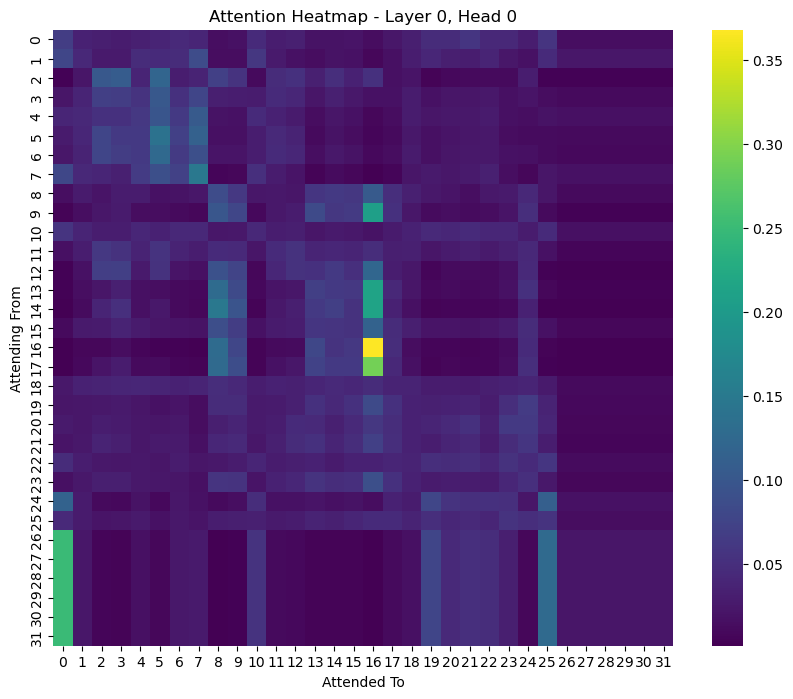

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Pick your layer and head
layer_idx = 0  # change this to see deeper layers
head_idx = 0   # or try other heads

# Get the attention matrix for that head in that layer
attn = attentions[layer_idx][0, head_idx].detach().cpu().numpy()  # shape [seq_len, seq_len]

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(attn, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title(f"Attention Heatmap - Layer {layer_idx}, Head {head_idx}")
plt.xlabel("Attended To")
plt.ylabel("Attending From")
plt.show()


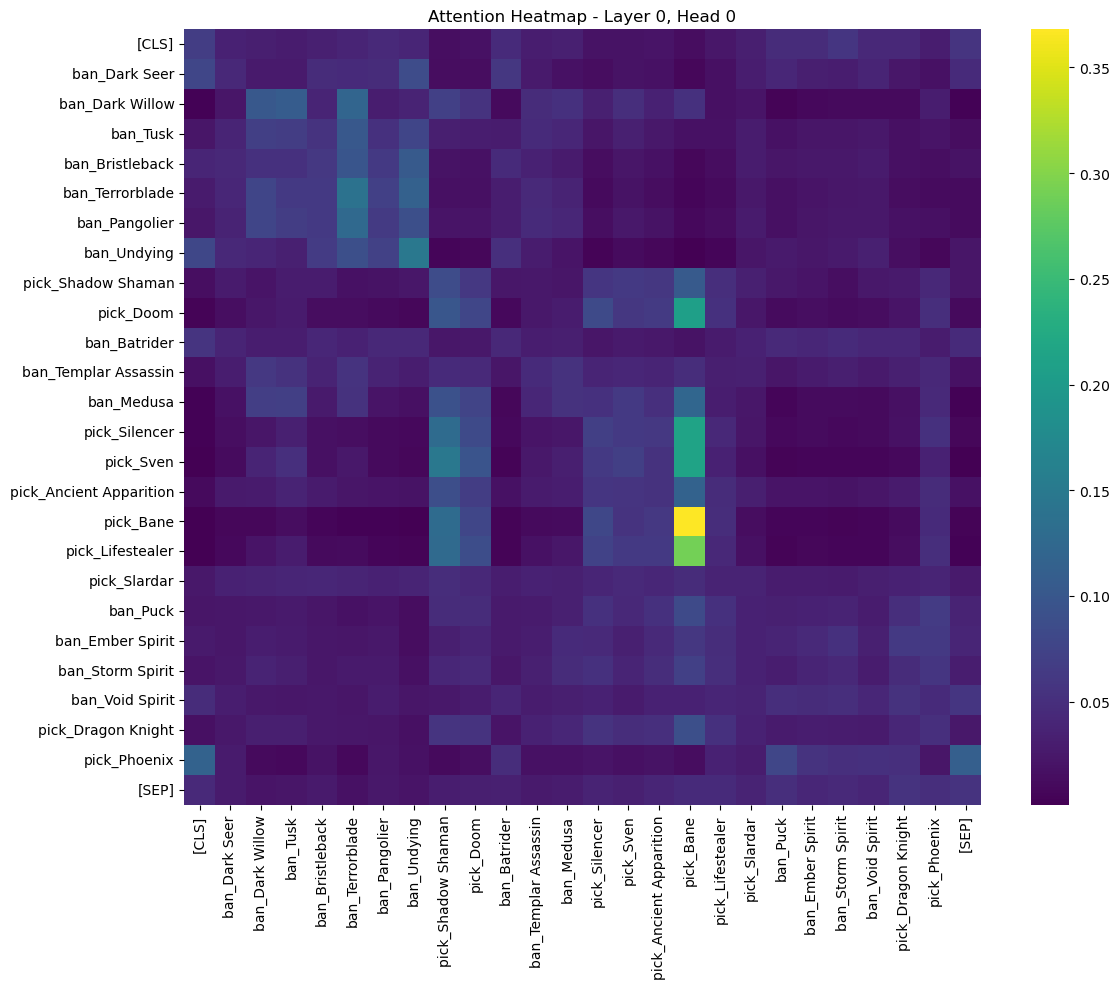

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

layer_idx = 0
head_idx = 0
seq_len = sample['attention_mask'].sum().item()

attn = attentions[layer_idx][0, head_idx][:seq_len, :seq_len].detach().cpu().numpy()
input_ids = sample['input_ids'][0]
tokens = [t.decode_token_id(tok.item()) for tok in input_ids[:seq_len]]

plt.figure(figsize=(12, 10))
sns.heatmap(attn, cmap="viridis", xticklabels=tokens, yticklabels=tokens)
plt.title(f"Attention Heatmap - Layer {layer_idx}, Head {head_idx}")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


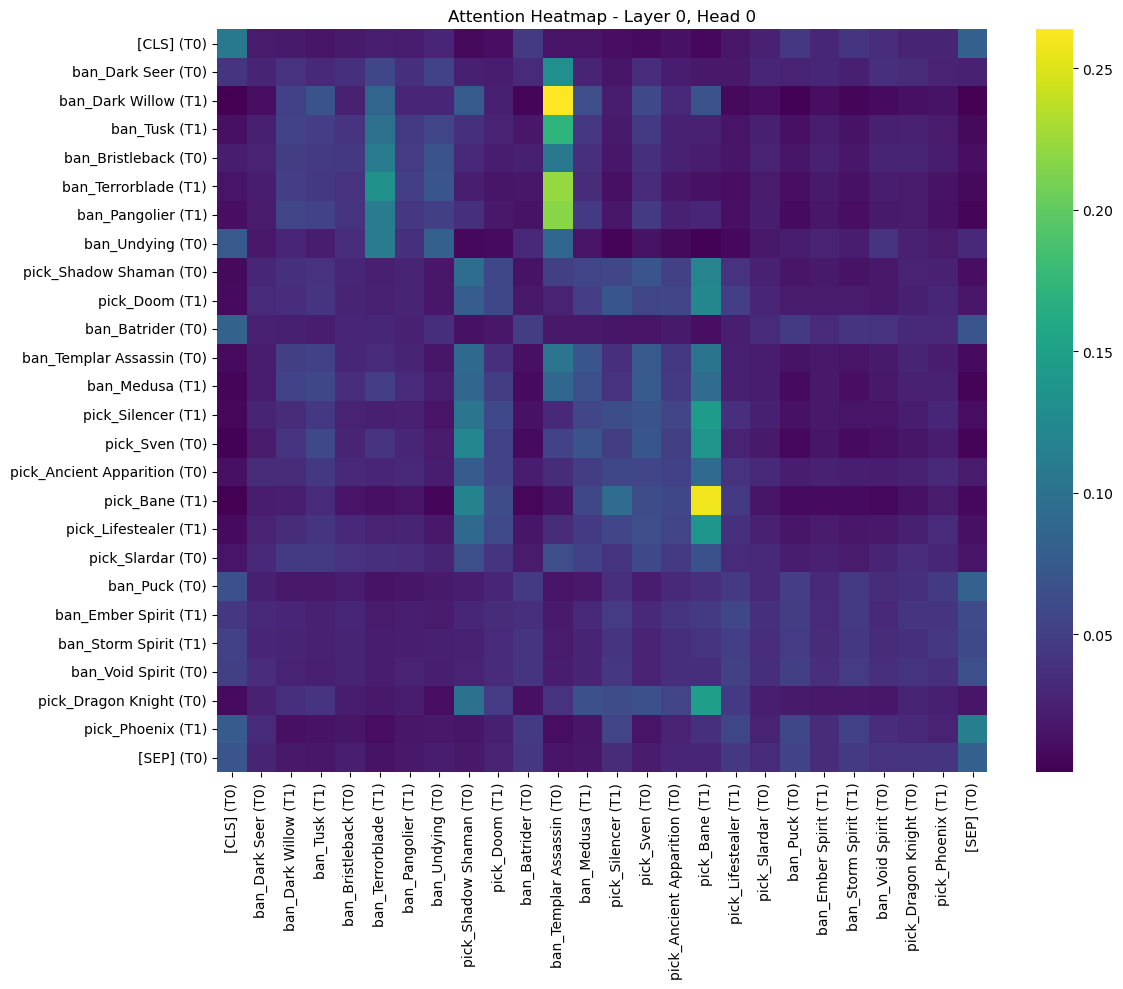

In [40]:
input_ids = sample['input_ids'][0]
team_ids = sample['team_ids'][0]

tokens = [
    f"{t.decode_token_id(tok.item())} (T{team_ids[i].item()})"
    for i, tok in enumerate(input_ids[:seq_len])
]

import seaborn as sns
import matplotlib.pyplot as plt

layer_idx = 0
head_idx = 0
seq_len = sample['attention_mask'].sum().item()

attn = attentions[layer_idx][0, head_idx][:seq_len, :seq_len].detach().cpu().numpy()
import numpy as np

# attentions[layer_idx] shape: [1, num_heads, seq_len, seq_len]
attn_all_heads = attentions[layer_idx][0]  # shape: [num_heads, seq_len, seq_len]
attn_avg = attn_all_heads.mean(dim=0)     # shape: [seq_len, seq_len]
attn_avg = attn_avg[:seq_len, :seq_len].detach().cpu().numpy()


# Normalize each row to sum to 1
attn_norm = attn / (attn.sum(axis=1, keepdims=True) + 1e-8)

input_ids = sample['input_ids'][0]
team_ids = sample['team_ids'][0]

tokens = [
    f"{t.decode_token_id(tok.item())} (T{team_ids[i].item()})"
    for i, tok in enumerate(input_ids[:seq_len])
]

plt.figure(figsize=(12, 10))
sns.heatmap(attn_avg, cmap="viridis", xticklabels=tokens, yticklabels=tokens)
plt.title(f"Attention Heatmap - Layer {layer_idx}, Head {head_idx}")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [43]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assume `sample` is your input (1 sample from the dataset)
# and `bmodel` is your model (BERT-style)
# Make sure `output_hidden_states=True` is passed
with torch.no_grad():
    outputs = bmodel(
        input_ids=sample["input_ids"].unsqueeze(0),
        attention_mask=sample["attention_mask"].unsqueeze(0),
        position_ids=sample["position_ids"].unsqueeze(0),
        team_ids=sample["team_ids"].unsqueeze(0),
        type_ids=sample["type_ids"].unsqueeze(0),
        #output_hidden_states=True
    )

# 1. Get last hidden states
last_hidden = outputs.last_hidden_states#[-1][0]  # [seq_len, hidden_dim]

# 2. Filter valid tokens
seq_len = sample['attention_mask'].sum().item()
valid_hidden = last_hidden[:seq_len]  # [valid_seq_len, hidden_dim]

# 3. Token names and optional team IDs
token_names = [t.decode_token_id(tok.item()) for tok in sample["input_ids"][:seq_len]]
team_ids = sample["team_ids"][:seq_len].tolist()

# 4. t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(valid_hidden.cpu().numpy())

# 5. Plot
plt.figure(figsize=(10, 8))
for (x, y), name, team in zip(embeddings_2d, token_names, team_ids):
    color = "blue" if team == 0 else "red"
    plt.scatter(x, y, c=color)
    plt.text(x + 0.1, y, name, fontsize=9, color=color)

plt.title("t-SNE of Token Embeddings (Last Hidden Layer)")
plt.axis("off")
plt.show()


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 5 is not equal to len(dims) = 4

In [19]:
import torch
import random
import json

from draft_gen import greedy_generate_draft_from_cut
from draft_tokenizer import DraftTokenizer
from draft_dataset import split_tokenized_docs
from transformers import GPT2Config
from draft_bert import DraftGPT2ForCausalLM

# === ⚙️ Load Tokenizer ===
t = DraftTokenizer.load_from_files()

# === 📜 Load Data ===
with open('draft_results.json', 'r') as f:
    draft_data = json.load(f)

docs = [seq for _, seq in draft_data.items()]
tokenized_docs = [t(doc, return_tensors='pt') for doc in docs]

# === ✂️ Test Split ===
_, _, test_docs = split_tokenized_docs(tokenized_docs, tokenizer=t, mid=True)
test_cases = random.sample(test_docs, k=3)

# === 📦 Load Model ===
gconfig = GPT2Config.from_pretrained("./model/final_gpt2_model")
gmodel = DraftGPT2ForCausalLM(gconfig)
gmodel.load_state_dict(torch.load("./model/final_gpt2_model/pytorch_model.bin"))
gmodel.eval().to('cuda' if torch.cuda.is_available() else 'cpu')

# === 🧪 Try Greedy Generation ===
for i, sample in enumerate(test_cases):
    print(f"\n===== 🤖 Greedy Search Generation: Case {i+1} =====")

    input_ids = sample['input_ids']
    valid_len = (sample['attention_mask'] > 0).sum().item()

    print("👀 Original Sequence:")
    print([t.decode_token_id(tok.item()) for tok in input_ids[:valid_len]])

    final_ids, log = greedy_generate_draft_from_cut(
        model=gmodel,
        tokenizer=t,
        sequence=sample,
        start_pos=18,
        max_len=32,
        top_k=5,
        model_type='gpt'
    )

    decoded = [t.decode_token_id(tok) for tok in final_ids if tok != t.pad_token_id]

    print("\n✅ Final Greedy Sequence:")
    print(" →", decoded)

    print("\n📊 Generation Log:")
    for step in log:
        tok = t.decode_token_id(step["predicted_token"])
        print(f"  Pos {step['position']:2d}: {tok:25s} (p={step['topk_probs'][0]:.4f})")

    print("\n📈 Top-k Alternatives Per Step:")
    for step in log:
        names = [t.decode_token_id(tok_id) for tok_id in step.get("topk_ids", [])]
        probs = step.get("topk_probs", [])
        print(f"  Step {step['position']}:")
        for name, p in zip(names, probs):
            print(f"    - {name:25s}: {p:.4f}")

    print("=" * 60)



===== 🤖 Greedy Search Generation: Case 1 =====
👀 Original Sequence:
['[CLS]', 'ban_Oracle', 'ban_Dark Willow', 'ban_Axe', 'ban_Beastmaster', 'ban_Batrider', 'ban_Templar Assassin', 'ban_Ancient Apparition', 'pick_Undying', 'pick_Tusk', 'ban_Lina', 'ban_Morphling', 'ban_Medusa', 'pick_Shadow Shaman', 'pick_Ringmaster', 'pick_Tiny', 'pick_Dawnbreaker', 'pick_Shadow Fiend', 'pick_Brewmaster', 'ban_Puck', 'ban_Terrorblade', 'ban_Muerta', 'ban_Snapfire', 'pick_Gyrocopter', 'pick_Dragon Knight', '[SEP]']


IndexError: too many indices for tensor of dimension 1

In [ ]:

# === 📦 Load BERT Model ===
from transformers import BertConfig
from draft_bert import DraftBertForMaskedLM

bconfig = BertConfig.from_pretrained("./model/final_bert_model")
bmodel = DraftBertForMaskedLM(bconfig)
bmodel.load_state_dict(torch.load("./model/final_bert_model/pytorch_model.bin"))
bmodel.eval().to('cuda' if torch.cuda.is_available() else 'cpu')

# === 🧪 Beam Search for BERT ===
for i, sample in enumerate(test_cases):
    print(f"\n===== 🧠 Beam Search Generation (BERT): Case {i+1} =====")

    input_ids = sample['input_ids']
    valid_len = (sample['attention_mask'] > 0).sum().item()

    print("👀 Original Sequence:")
    print([t.decode_token_id(tok.item()) for tok in input_ids[:valid_len]])

    beams = beam_generate_draft_from_cut(
        model=bmodel,
        tokenizer=t,
        sequence=sample,
        start_pos=18,
        beam_width=3,
        depth=6,
        max_len=32,
        model_type='bert'
    )

    top_beam = beams[0]
    final_tokens = top_beam["input_ids"][0]
    decoded = [t.decode_token_id(tok.item()) for tok in final_tokens if tok.item() != t.pad_token_id]

    print("\n✅ Top Beam (Best Sequence):")
    print(" →", decoded)
    print(f"🧮 Score: {top_beam['score']:.2f}")

    print("\n📊 Generation Log:")
    for step in top_beam["log"]:
        tok = t.decode_token_id(step["predicted_token"])
        print(f"  Pos {step['position']:2d}: {tok:25s} (p={step['prob']:.4f})")

    print("\n📈 Top-k Alternatives Per Step:")
    for step in top_beam["log"]:
        names = [t.decode_token_id(tok_id) for tok_id in step.get("topk_ids", [])]
        probs = step.get("topk_probs", [])
        print(f"  Step {step['position']}:")
        for name, p in zip(names, probs):
            print(f"    - {name:25s}: {p:.4f}")

    print("="*60)